In [ ]:
#import dataset with target volatility for each time id and stock id
import pandas as pd
import numpy as np
import plotly.express as px
train = pd.read_csv('train.csv')
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [ ]:
#import the whole book data
import os
from sklearn.metrics import r2_score
import glob
list_order_book_file_train = glob.glob('book_train.parquet/*')


In [6]:
print(list_order_book_file_train)

['book_train.parquet/stock_id=17', 'book_train.parquet/stock_id=28', 'book_train.parquet/stock_id=10', 'book_train.parquet/stock_id=26', 'book_train.parquet/stock_id=19', 'book_train.parquet/stock_id=21', 'book_train.parquet/stock_id=75', 'book_train.parquet/stock_id=81', 'book_train.parquet/stock_id=86', 'book_train.parquet/stock_id=72', 'book_train.parquet/stock_id=44', 'book_train.parquet/stock_id=88', 'book_train.parquet/stock_id=43', 'book_train.parquet/stock_id=20', 'book_train.parquet/stock_id=27', 'book_train.parquet/stock_id=18', 'book_train.parquet/stock_id=11', 'book_train.parquet/stock_id=16', 'book_train.parquet/stock_id=29', 'book_train.parquet/stock_id=89', 'book_train.parquet/stock_id=42', 'book_train.parquet/stock_id=73', 'book_train.parquet/stock_id=87', 'book_train.parquet/stock_id=80', 'book_train.parquet/stock_id=74', 'book_train.parquet/stock_id=103', 'book_train.parquet/stock_id=104', 'book_train.parquet/stock_id=105', 'book_train.parquet/stock_id=102', 'book_tra

In [7]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [ ]:
#functions to compute skewness and kourtosis
from numba import njit

@njit
def compute_skewness(arr):
    n = len(arr)
    mean_val = np.mean(arr)
    var_val = np.sum((arr - mean_val) ** 2) / (n - 1)
    std_val = np.sqrt(var_val)
    if std_val == 0:
        return 0.0
    skew = np.sum(((arr - mean_val) / std_val) ** 3) / n
    return skew

@njit
def compute_kurtosis(arr):
    n = len(arr)
    mean_val = np.mean(arr)
    var_val = np.sum((arr - mean_val) ** 2) / (n - 1)
    std_val = np.sqrt(var_val)
    if std_val == 0:
        return 0.0
    kurt = np.sum(((arr - mean_val) / std_val) ** 4) / n
    return kurt


@njit
def rolling_stat_min(arr, window, moment, min_periods):
    n_obs = len(arr)
    result = np.full(n_obs, np.nan)

    for i in range(n_obs):
        start = max(0, i - window + 1)
        window_slice = arr[start : i + 1]
        if len(window_slice) >= min_periods:
            if moment == 3:
                result[i] = compute_skewness(window_slice)
            elif moment == 4:
                result[i] = compute_kurtosis(window_slice)
    return result

In [ ]:
#compute features, for each time id we have six feature vectors 
def features_per_timeid(file_path, stock_id):
    df = pd.read_parquet(file_path)

    # WAP e log_return
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'] + 1e-6)
    df['log_return'] = df.groupby(['time_id'])['wap'].transform(log_return)

    # Spread
    df['spread'] = df['ask_price1'] - df['bid_price1']

    # Rolling volatility 10 ticks
    df['rolling_vol'] = df.groupby('time_id')['log_return'].transform(lambda x: x.rolling(window=10).std())

    # Rolling volatility 50 ticks
    df['rolling_vol_50'] = df.groupby('time_id')['log_return'].transform(lambda x: x.rolling(window=50, min_periods=10).std())

    # Rolling kurtosis 50 ticks
    df['rolling_kurtosis_50'] = df.groupby('time_id')['log_return'].transform(
    lambda x: pd.Series(rolling_stat_min(x.values, 50, moment=4, min_periods=10), index=x.index))

    df.fillna(0, inplace=True)
    features_list = [ 'log_return', 'spread', 'rolling_vol', 'rolling_vol_50', 'rolling_kurtosis_50','seconds_in_bucket']
    
    features_dict = {
    f'stockid{stock_id}_timeid{time_id}': group[features_list].values[10:]
    for time_id, group in df.groupby('time_id')}
    return features_dict



In [ ]:
#iterate for each stock
def features_per_stock(list_file):
    all_features = {}

    for file in list_file:
        stock_id = int(os.path.basename(file).split('=')[1].split('.')[0])
        one_stock = features_per_timeid(file, stock_id)
        all_features.update(one_stock)

    return all_features


In [ ]:
#create a dictionary with all features
all_features = features_per_stock(list_file=list_order_book_file_train)

In [ ]:
# Create a dictionary of targets for valid (stock_id, time_id) keys present in all_features
valid_keys = set(all_features.keys())

label_dict = {
    f'stockid{int(row["stock_id"])}_timeid{int(row["time_id"])}': row['target']
    for _, row in train.iterrows()
    if f'stockid{int(row["stock_id"])}_timeid{int(row["time_id"])}' in valid_keys
}


In [ ]:
# Build input sequences and targets for all keys that have labels in label_dict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

X_sequences = []
sequence_lengths = []
y_targets = []

for key, features in all_features.items():
    if key not in label_dict:
        continue
    X_sequences.append(features)
    sequence_lengths.append(len(features))
    y_targets.append(label_dict[key])

In [ ]:
# Custom collate function to pad sequences and convert batch data to tensors
# Prepare the dataset as a list of (sequence, target, length) tuples
def collate_fn(batch):
    sequences, targets, lengths = zip(*batch)
    sequences = [torch.tensor(seq).float() for seq in sequences]
    sequences_padded = pad_sequence(sequences, batch_first=True)  
    targets = torch.tensor(targets).float()
    lengths = torch.tensor(lengths)
    return sequences_padded, targets, lengths


dataset = list(zip(X_sequences, y_targets, sequence_lengths))


In [ ]:
from sklearn.model_selection import train_test_split

# Train 
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)

# Validation, test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 300252, Validation: 64340, Test: 64340


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for X_seq, _, _ in train_data:
    scaler.partial_fit(X_seq) 

In [ ]:

def apply_scaler(data, scaler):
    scaled_data = []
    for X_seq, target, seq_len in data:
        X_seq_scaled = scaler.transform(X_seq)
        scaled_data.append((X_seq_scaled, target, seq_len))
    return scaled_data

# Apply scaling
train_data_scaled = apply_scaler(train_data, scaler)
val_data_scaled = apply_scaler(val_data, scaler)
test_data_scaled = apply_scaler(test_data, scaler)

In [ ]:
#prepare data loaders
train_loader = DataLoader(train_data_scaled, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data_scaled, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data_scaled, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:

#  LSTM Regressor

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=4, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x_padded, lengths):
        packed_input = pack_padded_sequence(x_padded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed_input)
        h_n = h_n[-1]
        output = self.fc(h_n)
        return output.squeeze()
    

In [ ]:
#define the loss function RMSPE
class RMSPELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(RMSPELoss, self).__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        y_true_safe = torch.clamp(y_true, min=self.eps)
        pct_error = (y_pred - y_true_safe) / y_true_safe
        loss = torch.sqrt(torch.mean(pct_error ** 2))
        return loss

In [ ]:
#train the neural network, done on kaggle using GPU, we have saved the model and loaded directly in the next cell, no need to train again
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

model = LSTMRegressor(input_dim=6).to(device)

criterion = RMSPELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
best_val_loss = float('inf')
save_path = 'best_model.pth'
patience = 10
no_improve_epochs = 0

epochs = 50

for epoch in range(epochs):
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()

    # --- Training ---
    model.train()
    running_loss = 0.0
    for x_padded, y_batch, lengths in train_loader:
        x_padded, y_batch, lengths = x_padded.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        y_pred = model(x_padded, lengths)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_padded, y_batch, lengths in val_loader:
            x_padded, y_batch, lengths = x_padded.to(device), y_batch.to(device), lengths.to(device)
            y_pred = model(x_padded, lengths)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    scheduler.step(avg_val_loss)  
    # --- Timer ---
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    epoch_duration = time.time() - start_time

    # --- Print ---
    print(f"Epoch {epoch+1}/{epochs} - Train RMSPE: {avg_train_loss:.6f} - Validation RMSPE: {avg_val_loss:.6f} - Time: {epoch_duration:.2f}s")

    # --- Early stopping ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        no_improve_epochs = 0
        print(f"✅ Best model saved (Validation RMSPE: {avg_val_loss:.6f})")
    else:
        no_improve_epochs += 1
        print(f"❗ No improvement for {no_improve_epochs} epoch(s)")

    if no_improve_epochs >= patience:
        print(f"⏹️ Early stopping after {patience} epochs without improvement.")
        break

# Reload best model
model.load_state_dict(torch.load(save_path))
print("✅ Best model reloaded for final test/inference.")


✅ Using device: cuda
Epoch 1/50 - Train RMSPE: 0.530617 - Validation RMSPE: 0.432080 - Time: 427.28s
✅ Best model saved (Validation RMSPE: 0.432080)
Epoch 2/50 - Train RMSPE: 0.315831 - Validation RMSPE: 0.287764 - Time: 429.09s
✅ Best model saved (Validation RMSPE: 0.287764)
Epoch 3/50 - Train RMSPE: 0.293714 - Validation RMSPE: 0.372423 - Time: 433.04s
❗ No improvement for 1 epoch(s)
Epoch 4/50 - Train RMSPE: 0.282628 - Validation RMSPE: 0.339870 - Time: 432.19s
❗ No improvement for 2 epoch(s)
Epoch 5/50 - Train RMSPE: 0.280596 - Validation RMSPE: 0.292341 - Time: 434.11s
❗ No improvement for 3 epoch(s)
Epoch 6/50 - Train RMSPE: 0.273421 - Validation RMSPE: 0.251003 - Time: 433.17s
✅ Best model saved (Validation RMSPE: 0.251003)
Epoch 7/50 - Train RMSPE: 0.271447 - Validation RMSPE: 0.255788 - Time: 433.84s
❗ No improvement for 1 epoch(s)
Epoch 8/50 - Train RMSPE: 0.270340 - Validation RMSPE: 0.245736 - Time: 435.21s
✅ Best model saved (Validation RMSPE: 0.245736)
Epoch 9/50 - Train 

In [ ]:
#testing of the model
model = LSTMRegressor(input_dim=6)
model.load_state_dict(torch.load('Batch_64_LR_SP_V10_V50_K50_SB_32_0.2_4.pth', map_location=torch.device('cpu')))
model.eval()
criterion = RMSPELoss()

test_loss = 0.0
with torch.no_grad():
    for x_padded, y_batch, lengths in test_loader:
        x_padded, y_batch, lengths = x_padded, y_batch, lengths
        y_pred = model(x_padded, lengths)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"✅ Final Test RMSPE: {avg_test_loss:.6f}")


✅ Final Test RMSPE: 0.234886


In [ ]:

import numpy as np
import torch
import matplotlib.pyplot as plt

def rmspe(y_true, y_pred):
    pct_error = (y_pred - y_true) / (y_true + 1e-6)
    return torch.sqrt(torch.mean(pct_error ** 2)).item()

In [ ]:
# Evaluate permutation importance by zeroing out the selected feature and measuring the increase in validation loss (RMSPE) compared to the baseline
def permutation_importance(model, data_loader, base_val_loss, feature_idx):
    delta_losses = []

    for x_padded, y_batch, lengths in data_loader:
        x_padded, y_batch, lengths = x_padded, y_batch, lengths

        x_padded[:, :, feature_idx] = 0.0

        with torch.no_grad():
            y_pred = model(x_padded, lengths)

        loss = rmspe(y_batch, y_pred)
        delta_losses.append(loss)

    delta_loss = np.mean(delta_losses) - base_val_loss
    return delta_loss

In [ ]:
def evaluate_feature_importance(model, val_loader, feature_names):
    model.eval()
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for x_padded, y_batch, lengths in val_loader:
            x_padded, y_batch, lengths = x_padded, y_batch, lengths
            y_pred = model(x_padded, lengths)
            y_preds.append(y_pred.cpu())
            y_trues.append(y_batch.cpu())

    y_preds = torch.cat(y_preds)
    y_trues = torch.cat(y_trues)
    base_val_loss = rmspe(y_trues, y_preds)

    print(f"Baseline Validation RMSPE: {base_val_loss:.6f}")

    # Feature Importance calculation
    importance_scores = []
    for idx, feature_name in enumerate(feature_names):
        delta = permutation_importance(model, val_loader, base_val_loss, idx)
        importance_scores.append(delta)
        print(f"Feature: {feature_name} ➔ Delta RMSPE: {delta:.6f}")

    # Barplot
    sorted_indices = np.argsort(importance_scores)[::-1]
    plt.figure(figsize=(10, 6))
    bars = plt.barh([feature_names[i] for i in sorted_indices], [importance_scores[i] for i in sorted_indices], color='skyblue')

    for bar, delta in zip(bars, [importance_scores[i] for i in sorted_indices]):
        if delta < 0:
            bar.set_color('salmon')

    plt.xlabel('Increase in RMSPE (Feature Importance)')
    plt.title('Feature Importance via Permutation')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

Baseline Validation RMSPE: 0.235795
Feature: log_return ➔ Delta RMSPE: 0.028345
Feature: spread ➔ Delta RMSPE: 0.051084
Feature: rolling_vol ➔ Delta RMSPE: 0.128037
Feature: rolling_vol_50 ➔ Delta RMSPE: 0.265333
Feature: rolling_kurtosis_50 ➔ Delta RMSPE: 0.012734
Feature: seconds_in_bucket ➔ Delta RMSPE: 0.009023


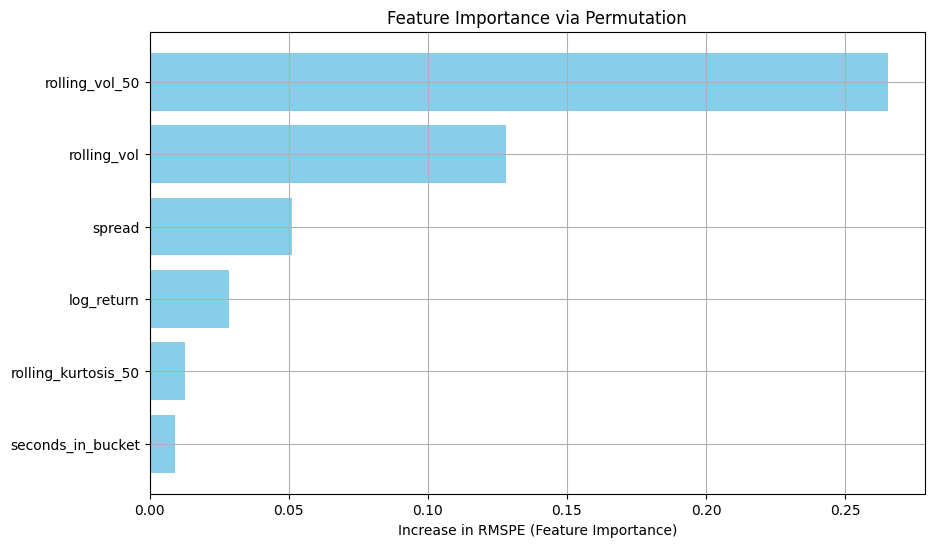

In [ ]:
feature_names = features_list =['log_return', 'spread','rolling_vol', 'rolling_vol_50', 'rolling_kurtosis_50', 'seconds_in_bucket']
evaluate_feature_importance(model, val_loader, feature_names)
# The rolling volatility is the most important feature used by the model